In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob
images = glob.glob('./camera_cal/calibration*.jpg')
objpoints = []
imgpoints = []
nx = 9
ny = 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        #imgX = cv2.drawChessboardCorners(img, (nx,ny), corners, ret) 
        #plt.imshow(imgX)
        #print(fname)

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    # undist = np.copy(img)  # Delete this line
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,gray.shape[::-1],None,None)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted, mtx, dist

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allxLeft = None  
        self.allxRight = None  
        #y values for detected line pixels
        self.ally = None  
        # Used Method (1: Slide, 2: Prior)
        self.Method = None 
        self.SanityChkFail = 0

In [13]:
def corners_unwarp(undist, vertices):
    ofs = 0 # offset for dst points
    # Grab the image shape
    img_size = (undist.shape[1], undist.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([(vertices[0][1][0],vertices[0][1][1]), (vertices[0][2][0],vertices[0][2][1]), (vertices[0][3][0],vertices[0][3][1]), (vertices[0][0][0],vertices[0][0][1])])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[((vertices[0][0][0]+vertices[0][1][0])/2)-ofs, 0], 
                      [((vertices[0][2][0]+vertices[0][3][0])/2)+ofs, 0], 
                      [((vertices[0][2][0]+vertices[0][3][0])/2)+ofs, img.shape[0]], 
                      [((vertices[0][0][0]+vertices[0][1][0])/2)-ofs, img.shape[0]]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped, M, dst, Minv

def abs_sobel_thresh(image, orient='x', thresh_min=0, thresh_max=255):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        LineStoredTmp.detected = 1
    except ValueError:
        # Avoids an error if the above is not implemented fully
        LineStoredTmp.detected = 0
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        LineStoredTmp.detected = 1
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        LineStoredTmp.detected = 0
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

def CurveRad(ploty, left_fit, right_fit, left_fitx, right_fitx):
    y_eval = np.max(ploty)
    my = 40/720 # meters per pixel in y dimension
    mx = 3.7/500 # meters per pixel in x dimension

    AveFitx = (left_fitx + right_fitx)/2
    AveFit = np.polyfit(ploty, AveFitx, 2)
    LeftAX = 2*AveFit[0]*(mx / (my ** 2))
    LeftBX = left_fit[1]*(mx/my)
    AveCurv = ((1+((LeftAX)*y_eval + LeftBX)**2)**1.5)/abs(LeftAX)
    CurvRadText = "Radius of Curvature: %dm", AveCurv
    CurvRad = AveCurv
    MidPoint = AveFit[0]*y_eval**2 + AveFit[1]*y_eval + AveFit[2]
    Shifted = (img.shape[1]/2 - MidPoint)*mx
    if Shifted <= 0:
        ShiftText = "left"
    else:
        ShiftText = "right"
    return CurvRad, ShiftText, Shifted

def ProcessImageSlide(warped,undistorted, Minv):
    out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped)
     
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 255))

    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    CurvRad, ShiftText, Shifted = CurveRad(ploty, left_fit, right_fit, left_fitx, right_fitx)
    cv2.putText(result, "Radius of Curvature: %dm" % CurvRad,(50,50), cv2.FONT_HERSHEY_COMPLEX, 1,(255,255,0),2,cv2.LINE_AA)
    cv2.putText(result, "Vehicle is %.2fm %s of center" % (abs(Shifted), ShiftText),(50,100), cv2.FONT_HERSHEY_COMPLEX, 1,(255,255,0),2,cv2.LINE_AA)

    LineStoredTmp.current_fit = [left_fit, right_fit]
    LineStoredTmp.allxLeft = left_fitx
    LineStoredTmp.allxRight = right_fitx
    LineStoredTmp.ally = ploty
    LineStoredTmp.radius_of_curvature = CurvRad
    LineStoredTmp.line_base_pos = Shifted
    return result

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def ProcessImagePrior(binary_warped,undistorted, Minv):
    if LineStoredSane.SanityChkFail < 1:
        left_fit = LineStoredSane.current_fit[0]
        right_fit = LineStoredSane.current_fit[1]
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    else:
        left_fitx = (LineStoredSane.allxLeft + LineStoredTmp.allxLeft)/2
        right_fitx = (LineStoredSane.allxRight + LineStoredTmp.allxRight)/2
        ploty = (LineStoredSane.ally + LineStoredTmp.ally)/2
        left_fit = (LineStoredTmp.current_fit[0] + LineStoredTmp.current_fit[0])/2
        right_fit = (LineStoredTmp.current_fit[1] + LineStoredTmp.current_fit[1])/2
        #left_fitx = LineStoredSane.allxLeft
        #right_fitx = LineStoredSane.allxRight
        #ploty = LineStoredSane.ally
        #left_fit = LineStoredTmp.current_fit[0]
        #right_fit = LineStoredTmp.current_fit[1]
    ## Visualization ##
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 255))
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    CurvRad, ShiftText, Shifted = CurveRad(ploty, left_fit, right_fit, left_fitx, right_fitx)
    cv2.putText(result, "Radius of Curvature: %dm" % CurvRad,(50,50), cv2.FONT_HERSHEY_COMPLEX, 1,(255,255,0),2,cv2.LINE_AA)
    cv2.putText(result, "Vehicle is %.2fm %s of center" % (abs(Shifted), ShiftText),(50,100), cv2.FONT_HERSHEY_COMPLEX, 1,(255,255,0),2,cv2.LINE_AA)

    LineStoredTmp.current_fit = [left_fit, right_fit]
    LineStoredTmp.allxLeft = left_fitx
    LineStoredTmp.allxRight = right_fitx
    LineStoredTmp.ally = ploty
    LineStoredTmp.radius_of_curvature = CurvRad
    LineStoredTmp.line_base_pos = Shifted
    return result

In [14]:
def ImageProcess(img):
    undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)
    imshape = img.shape
    LeftBottom = (180,imshape[0])
    RightBottom = (1150,imshape[0])
    LeftTop = (590,450)
    RightTop = (690,450)
    vertices = np.array([[LeftBottom,LeftTop, RightTop, RightBottom]], dtype=np.int32)

    gradx = abs_sobel_thresh(undistorted, orient='x', thresh_min = 30, thresh_max = 100)
    grady = abs_sobel_thresh(undistorted, orient='y', thresh_min = 50, thresh_max = 100)
    mag_binary = mag_thresh(undistorted, sobel_kernel=9, mag_thresh=(80,150))
    dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.8,1.2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    hls_binary = hls_select(undistorted, thresh=(150, 200))
    combinedAll = np.zeros_like(dir_binary)
    combinedAll[(combined == 1) | (hls_binary == 1)] = 1

    warped, M, dst, Minv = corners_unwarp(combinedAll, vertices)

    if ((LineStoredSane.detected == 1) & (LineStoredSane.SanityChkFail < 2)):
        UpdatedImage = ProcessImagePrior(warped, undistorted, Minv)
        #print(LineStored.Method)
    else:
        UpdatedImage = ProcessImageSlide(warped, undistorted, Minv)
        #print(LineStored.Method)
    SanityCheck()
    if LineStoredSane.SanityChkFail > 0:
        UpdatedImage = ProcessImagePrior(warped, undistorted, Minv)
        
    return UpdatedImage

In [15]:
def SanityCheck():
    CurvRad = LineStoredTmp.radius_of_curvature
    Shifted = LineStoredTmp.line_base_pos
    left_fitx = LineStoredTmp.allxLeft
    right_fitx = LineStoredTmp.allxRight
    if ((LineStoredSane.radius_of_curvature != None) & (LineStoredSane.line_base_pos != None)):
        # Curvature
        if abs(LineStoredSane.radius_of_curvature - CurvRad) < 1000:
            CurvCheck = 1
        else:
            CurvCheck = 0
        # Horizontal
        if abs(LineStoredSane.line_base_pos - Shifted) < 1:
            HorzCheck = 1
        else:
            HorzCheck = 0
        # Parallel
        CheckNum = 10
        diffTmp = [None] * (CheckNum+1)
        for i in range(0, CheckNum):
            xLeft = left_fitx[int(i*len(left_fitx)/CheckNum)]
            xRight = right_fitx[int(i*len(right_fitx)/CheckNum)]
            diffTmp[i] = xLeft-xRight
            diffChkTmp = 0
            if i != 0:
                if abs(diffTmp[i] - diffTmp[i-1]) < 200:
                    diffChkTmp += 1
        if diffChkTmp < 2:
            ParallelCheck = 1
        else:
            ParallelCheck = 0
        SanityChk = CurvCheck & HorzCheck & ParallelCheck
    else:
        SanityChk = 1
    
    # Sanity
    if SanityChk == 1:
        LineStoredSane.current_fit = LineStoredTmp.current_fit
        LineStoredSane.allxLeft = LineStoredTmp.allxLeft
        LineStoredSane.allxRight = LineStoredTmp.allxRight
        LineStoredSane.radius_of_curvature = LineStoredTmp.radius_of_curvature
        LineStoredSane.line_base_pos = LineStoredTmp.line_base_pos
        LineStoredSane.SanityChkFail = 0
        LineStoredSane.detected = 1
        LineStoredSane.ally = LineStoredTmp.ally
    else:
        LineStoredSane.SanityChkFail += 1
        if LineStoredSane.SanityChkFail > 2:
            LineStoredSane.detected = 0
            print("Sanity Failed!")
    return

In [16]:
LineStoredTmp = Line()
LineStoredSane = Line()

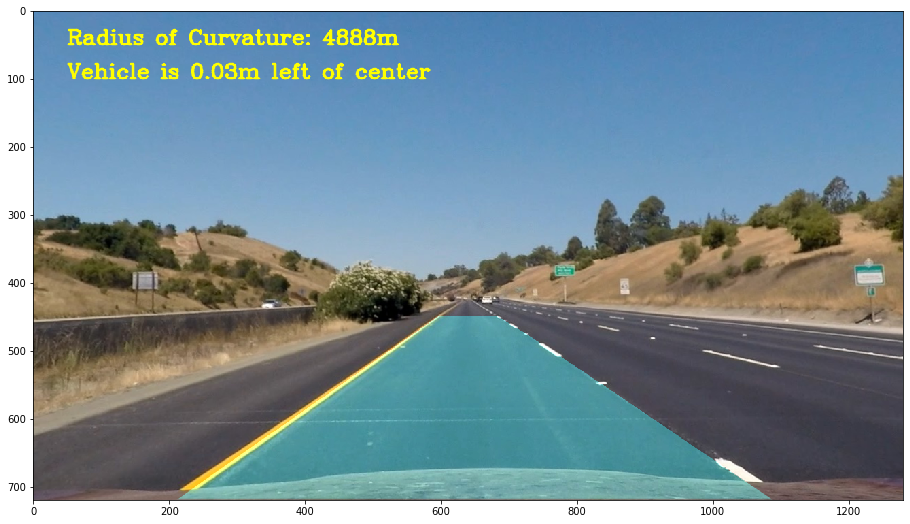

In [17]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
#img = mpimg.imread('./test_images/straight_lines2.jpg')

result = ImageProcess(img)
f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
plt.imshow(result)

In [18]:
### This section allows to load a video and process it to find lane lines. Video will be played directly during process.
cap = cv2.VideoCapture('project_video.mp4')
#cap = cv2.VideoCapture('test_videos/solidYellowLeft.mp4')
vid_cod = cv2.VideoWriter_fourcc(*'XVID')
LineStoredTmp = Line()
LineStoredSane = Line()
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret: 
        UpdatedPicture = ImageProcess(frame) 
        cv2.imshow('frame',UpdatedPicture)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [19]:
### This section allows to load solidWhiteRight video and process it to find lane lines. Video will be played after saving the file.
from moviepy.editor import VideoFileClip
from IPython.display import HTML
LineStoredTmp = Line()
LineStoredSane = Line()
white_output = 'project_videoX.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
white_clip = clip1.fl_image(ImageProcess) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video project_videoX.mp4.
Moviepy - Writing video project_videoX.mp4



t:  26%|██▋       | 331/1260 [06:17<18:21,  1.19s/it, now=None]

Sanity Failed!


t:  26%|██▋       | 332/1260 [06:18<18:21,  1.19s/it, now=None]

Sanity Failed!


t:  26%|██▋       | 333/1260 [06:19<18:05,  1.17s/it, now=None]

Sanity Failed!


t:  27%|██▋       | 334/1260 [06:20<17:49,  1.16s/it, now=None]

Sanity Failed!


t:  27%|██▋       | 335/1260 [06:21<17:41,  1.15s/it, now=None]

Sanity Failed!


t:  27%|██▋       | 336/1260 [06:23<17:34,  1.14s/it, now=None]

Sanity Failed!


t:  27%|██▋       | 337/1260 [06:24<17:27,  1.14s/it, now=None]

Sanity Failed!


t:  27%|██▋       | 338/1260 [06:25<17:50,  1.16s/it, now=None]

Sanity Failed!


t:  27%|██▋       | 339/1260 [06:26<18:13,  1.19s/it, now=None]

Sanity Failed!


t:  27%|██▋       | 340/1260 [06:27<18:12,  1.19s/it, now=None]

Sanity Failed!


t:  27%|██▋       | 341/1260 [06:29<18:17,  1.19s/it, now=None]

Sanity Failed!


t:  27%|██▋       | 342/1260 [06:30<18:00,  1.18s/it, now=None]

Sanity Failed!


t:  28%|██▊       | 356/1260 [06:46<17:34,  1.17s/it, now=None]

Sanity Failed!


t:  29%|██▉       | 371/1260 [07:06<17:50,  1.20s/it, now=None]

Sanity Failed!


t:  30%|██▉       | 372/1260 [07:07<17:46,  1.20s/it, now=None]

Sanity Failed!


t:  30%|██▉       | 373/1260 [07:08<17:23,  1.18s/it, now=None]

Sanity Failed!


t:  30%|██▉       | 374/1260 [07:09<17:13,  1.17s/it, now=None]

Sanity Failed!


t:  30%|██▉       | 375/1260 [07:10<17:05,  1.16s/it, now=None]

Sanity Failed!


t:  30%|██▉       | 376/1260 [07:11<17:07,  1.16s/it, now=None]

Sanity Failed!


t:  30%|██▉       | 377/1260 [07:13<17:21,  1.18s/it, now=None]

Sanity Failed!


t:  30%|███       | 378/1260 [07:14<18:03,  1.23s/it, now=None]

Sanity Failed!


t:  30%|███       | 379/1260 [07:15<17:43,  1.21s/it, now=None]

Sanity Failed!


t:  30%|███       | 380/1260 [07:16<17:26,  1.19s/it, now=None]

Sanity Failed!


t:  30%|███       | 381/1260 [07:17<17:27,  1.19s/it, now=None]

Sanity Failed!


t:  30%|███       | 382/1260 [07:19<17:13,  1.18s/it, now=None]

Sanity Failed!


t:  33%|███▎      | 413/1260 [07:54<16:14,  1.15s/it, now=None]

Sanity Failed!


t:  33%|███▎      | 419/1260 [08:01<17:33,  1.25s/it, now=None]

Sanity Failed!


t:  33%|███▎      | 420/1260 [08:03<17:28,  1.25s/it, now=None]

Sanity Failed!


t:  33%|███▎      | 421/1260 [08:04<17:27,  1.25s/it, now=None]

Sanity Failed!


t:  34%|███▍      | 430/1260 [08:15<17:43,  1.28s/it, now=None]

Sanity Failed!


t:  34%|███▍      | 431/1260 [08:17<18:32,  1.34s/it, now=None]

Sanity Failed!


t:  35%|███▍      | 437/1260 [08:25<19:40,  1.43s/it, now=None]

Sanity Failed!


t:  35%|███▍      | 438/1260 [08:27<19:26,  1.42s/it, now=None]

Sanity Failed!


t:  35%|███▍      | 439/1260 [08:28<19:16,  1.41s/it, now=None]

Sanity Failed!


t:  35%|███▌      | 444/1260 [08:35<18:18,  1.35s/it, now=None]

Sanity Failed!


t:  35%|███▌      | 445/1260 [08:36<18:25,  1.36s/it, now=None]

Sanity Failed!


t:  35%|███▌      | 446/1260 [08:37<18:04,  1.33s/it, now=None]

Sanity Failed!


t:  35%|███▌      | 447/1260 [08:39<17:59,  1.33s/it, now=None]

Sanity Failed!


t:  36%|███▌      | 448/1260 [08:40<17:35,  1.30s/it, now=None]

Sanity Failed!


t:  36%|███▌      | 449/1260 [08:41<16:59,  1.26s/it, now=None]

Sanity Failed!


t:  36%|███▌      | 450/1260 [08:42<16:26,  1.22s/it, now=None]

Sanity Failed!


t:  36%|███▌      | 451/1260 [08:43<16:10,  1.20s/it, now=None]

Sanity Failed!


t:  36%|███▌      | 452/1260 [08:45<15:57,  1.18s/it, now=None]

Sanity Failed!


t:  36%|███▌      | 453/1260 [08:46<15:40,  1.17s/it, now=None]

Sanity Failed!


t:  36%|███▌      | 454/1260 [08:47<15:29,  1.15s/it, now=None]

Sanity Failed!


t:  36%|███▌      | 455/1260 [08:48<15:24,  1.15s/it, now=None]

Sanity Failed!


t:  37%|███▋      | 463/1260 [08:57<14:36,  1.10s/it, now=None]

Sanity Failed!


t:  37%|███▋      | 470/1260 [09:05<14:22,  1.09s/it, now=None]

Sanity Failed!


t:  37%|███▋      | 471/1260 [09:06<14:33,  1.11s/it, now=None]

Sanity Failed!


t:  39%|███▊      | 486/1260 [09:22<14:15,  1.11s/it, now=None]

Sanity Failed!


t:  39%|███▊      | 487/1260 [09:23<14:29,  1.13s/it, now=None]

Sanity Failed!


t:  39%|███▊      | 488/1260 [09:24<14:38,  1.14s/it, now=None]

Sanity Failed!


t:  39%|███▉      | 489/1260 [09:26<14:38,  1.14s/it, now=None]

Sanity Failed!


t:  39%|███▉      | 490/1260 [09:27<14:31,  1.13s/it, now=None]

Sanity Failed!


t:  39%|███▉      | 491/1260 [09:28<14:34,  1.14s/it, now=None]

Sanity Failed!


t:  39%|███▉      | 492/1260 [09:29<14:32,  1.14s/it, now=None]

Sanity Failed!


t:  39%|███▉      | 493/1260 [09:30<14:31,  1.14s/it, now=None]

Sanity Failed!


t:  39%|███▉      | 494/1260 [09:32<15:27,  1.21s/it, now=None]

Sanity Failed!


t:  39%|███▉      | 495/1260 [09:33<15:27,  1.21s/it, now=None]

Sanity Failed!


t:  39%|███▉      | 496/1260 [09:34<15:15,  1.20s/it, now=None]

Sanity Failed!


t:  39%|███▉      | 497/1260 [09:35<15:12,  1.20s/it, now=None]

Sanity Failed!


t:  40%|███▉      | 498/1260 [09:36<15:26,  1.22s/it, now=None]

Sanity Failed!


t:  40%|███▉      | 499/1260 [09:38<15:20,  1.21s/it, now=None]

Sanity Failed!


t:  40%|███▉      | 500/1260 [09:39<14:56,  1.18s/it, now=None]

Sanity Failed!


t:  40%|████      | 506/1260 [09:45<14:33,  1.16s/it, now=None]

Sanity Failed!


t:  40%|████      | 507/1260 [09:47<14:41,  1.17s/it, now=None]

Sanity Failed!


t:  40%|████      | 508/1260 [09:48<14:52,  1.19s/it, now=None]

Sanity Failed!


t:  40%|████      | 509/1260 [09:49<15:07,  1.21s/it, now=None]

Sanity Failed!


t:  40%|████      | 510/1260 [09:50<15:03,  1.20s/it, now=None]

Sanity Failed!


t:  41%|████      | 511/1260 [09:52<15:01,  1.20s/it, now=None]

Sanity Failed!


t:  41%|████      | 512/1260 [09:53<15:03,  1.21s/it, now=None]

Sanity Failed!


t:  41%|████      | 513/1260 [09:54<15:04,  1.21s/it, now=None]

Sanity Failed!


t:  41%|████      | 514/1260 [09:55<14:47,  1.19s/it, now=None]

Sanity Failed!


t:  41%|████▏     | 520/1260 [10:02<14:03,  1.14s/it, now=None]

Sanity Failed!


t:  41%|████▏     | 521/1260 [10:03<14:03,  1.14s/it, now=None]

Sanity Failed!


t:  41%|████▏     | 522/1260 [10:04<13:58,  1.14s/it, now=None]

Sanity Failed!


t:  42%|████▏     | 523/1260 [10:05<14:03,  1.14s/it, now=None]

Sanity Failed!


t:  42%|████▏     | 527/1260 [10:10<13:58,  1.14s/it, now=None]

Sanity Failed!


t:  43%|████▎     | 537/1260 [10:21<13:41,  1.14s/it, now=None]

Sanity Failed!


t:  43%|████▎     | 538/1260 [10:22<13:40,  1.14s/it, now=None]

Sanity Failed!


t:  43%|████▎     | 539/1260 [10:24<13:35,  1.13s/it, now=None]

Sanity Failed!


t:  43%|████▎     | 546/1260 [10:32<14:39,  1.23s/it, now=None]

Sanity Failed!


t:  43%|████▎     | 547/1260 [10:33<14:24,  1.21s/it, now=None]

Sanity Failed!


t:  45%|████▍     | 562/1260 [10:50<13:00,  1.12s/it, now=None]

Sanity Failed!


t:  45%|████▍     | 566/1260 [10:54<12:50,  1.11s/it, now=None]

Sanity Failed!


t:  45%|████▌     | 567/1260 [10:56<12:56,  1.12s/it, now=None]

Sanity Failed!


t:  45%|████▌     | 568/1260 [10:57<13:06,  1.14s/it, now=None]

Sanity Failed!


t:  46%|████▌     | 579/1260 [11:09<12:24,  1.09s/it, now=None]

Sanity Failed!


t:  46%|████▌     | 580/1260 [11:10<12:28,  1.10s/it, now=None]

Sanity Failed!


t:  46%|████▌     | 581/1260 [11:11<12:35,  1.11s/it, now=None]

Sanity Failed!


t:  46%|████▌     | 582/1260 [11:12<12:39,  1.12s/it, now=None]

Sanity Failed!


t:  46%|████▋     | 583/1260 [11:13<12:56,  1.15s/it, now=None]

Sanity Failed!


t:  46%|████▋     | 584/1260 [11:15<12:46,  1.13s/it, now=None]

Sanity Failed!


t:  46%|████▋     | 585/1260 [11:16<13:00,  1.16s/it, now=None]

Sanity Failed!


t:  47%|████▋     | 586/1260 [11:17<12:52,  1.15s/it, now=None]

Sanity Failed!


t:  47%|████▋     | 587/1260 [11:18<12:46,  1.14s/it, now=None]

Sanity Failed!


t:  47%|████▋     | 597/1260 [11:29<12:18,  1.11s/it, now=None]

Sanity Failed!


t:  47%|████▋     | 598/1260 [11:30<12:25,  1.13s/it, now=None]

Sanity Failed!


t:  48%|████▊     | 599/1260 [11:31<12:23,  1.13s/it, now=None]

Sanity Failed!


t:  48%|████▊     | 600/1260 [11:32<12:25,  1.13s/it, now=None]

Sanity Failed!


t:  48%|████▊     | 601/1260 [11:34<12:26,  1.13s/it, now=None]

Sanity Failed!


t:  48%|████▊     | 602/1260 [11:35<12:21,  1.13s/it, now=None]

Sanity Failed!


t:  48%|████▊     | 603/1260 [11:36<12:22,  1.13s/it, now=None]

Sanity Failed!


t:  48%|████▊     | 604/1260 [11:37<12:21,  1.13s/it, now=None]

Sanity Failed!


t:  48%|████▊     | 605/1260 [11:38<12:23,  1.13s/it, now=None]

Sanity Failed!


t:  48%|████▊     | 606/1260 [11:39<12:23,  1.14s/it, now=None]

Sanity Failed!


t:  78%|███████▊  | 980/1260 [18:37<06:25,  1.38s/it, now=None]

Sanity Failed!


t:  78%|███████▊  | 981/1260 [18:38<06:17,  1.35s/it, now=None]

Sanity Failed!


t:  78%|███████▊  | 982/1260 [18:39<06:10,  1.33s/it, now=None]

Sanity Failed!


t:  78%|███████▊  | 983/1260 [18:40<06:02,  1.31s/it, now=None]

Sanity Failed!


t:  78%|███████▊  | 984/1260 [18:42<06:34,  1.43s/it, now=None]

Sanity Failed!


t:  78%|███████▊  | 985/1260 [18:43<06:17,  1.37s/it, now=None]

Sanity Failed!


t:  78%|███████▊  | 986/1260 [18:45<06:06,  1.34s/it, now=None]

Sanity Failed!


t:  78%|███████▊  | 987/1260 [18:46<05:54,  1.30s/it, now=None]

Sanity Failed!


t:  78%|███████▊  | 988/1260 [18:47<05:46,  1.27s/it, now=None]

Sanity Failed!


t:  78%|███████▊  | 989/1260 [18:48<05:30,  1.22s/it, now=None]

Sanity Failed!


t:  79%|███████▊  | 990/1260 [18:49<05:19,  1.18s/it, now=None]

Sanity Failed!


t:  79%|███████▊  | 991/1260 [18:50<05:13,  1.17s/it, now=None]

Sanity Failed!


t:  79%|███████▊  | 992/1260 [18:51<05:06,  1.14s/it, now=None]

Sanity Failed!


t:  79%|███████▉  | 993/1260 [18:53<05:08,  1.15s/it, now=None]

Sanity Failed!


t:  79%|███████▉  | 994/1260 [18:54<05:05,  1.15s/it, now=None]

Sanity Failed!


t:  79%|███████▉  | 995/1260 [18:55<05:03,  1.14s/it, now=None]

Sanity Failed!


t:  79%|███████▉  | 996/1260 [18:56<04:59,  1.14s/it, now=None]

Sanity Failed!


t:  79%|███████▉  | 997/1260 [18:57<05:09,  1.18s/it, now=None]

Sanity Failed!


t:  79%|███████▉  | 998/1260 [18:58<05:05,  1.17s/it, now=None]

Sanity Failed!


t:  79%|███████▉  | 999/1260 [18:59<05:00,  1.15s/it, now=None]

Sanity Failed!


t:  79%|███████▉  | 1000/1260 [19:01<04:56,  1.14s/it, now=None]

Sanity Failed!


t:  79%|███████▉  | 1001/1260 [19:02<04:53,  1.13s/it, now=None]

Sanity Failed!


t:  80%|███████▉  | 1002/1260 [19:03<04:55,  1.15s/it, now=None]

Sanity Failed!


t:  80%|███████▉  | 1003/1260 [19:04<04:56,  1.15s/it, now=None]

Sanity Failed!


t:  80%|███████▉  | 1004/1260 [19:05<04:58,  1.17s/it, now=None]

Sanity Failed!


t:  80%|███████▉  | 1005/1260 [19:06<04:58,  1.17s/it, now=None]

Sanity Failed!


t:  80%|███████▉  | 1006/1260 [19:08<04:58,  1.18s/it, now=None]

Sanity Failed!


t:  80%|███████▉  | 1007/1260 [19:09<04:53,  1.16s/it, now=None]

Sanity Failed!


t:  80%|████████  | 1008/1260 [19:10<04:53,  1.16s/it, now=None]

Sanity Failed!


t:  80%|████████  | 1009/1260 [19:11<04:54,  1.17s/it, now=None]

Sanity Failed!


t:  80%|████████  | 1010/1260 [19:12<04:54,  1.18s/it, now=None]

Sanity Failed!


t:  80%|████████  | 1011/1260 [19:14<05:05,  1.23s/it, now=None]

Sanity Failed!


t:  80%|████████  | 1012/1260 [19:15<05:00,  1.21s/it, now=None]

Sanity Failed!


t:  80%|████████  | 1013/1260 [19:16<05:17,  1.29s/it, now=None]

Sanity Failed!


t:  80%|████████  | 1014/1260 [19:18<05:44,  1.40s/it, now=None]

Sanity Failed!


t:  81%|████████  | 1015/1260 [19:19<05:40,  1.39s/it, now=None]

Sanity Failed!


t:  81%|████████  | 1016/1260 [19:20<05:21,  1.32s/it, now=None]

Sanity Failed!


t:  81%|████████  | 1017/1260 [19:22<05:15,  1.30s/it, now=None]

Sanity Failed!


t:  99%|█████████▉| 1245/1260 [23:39<00:16,  1.10s/it, now=None]

Sanity Failed!


t:  99%|█████████▉| 1246/1260 [23:41<00:15,  1.10s/it, now=None]

Sanity Failed!


Moviepy - Done !
Moviepy - video ready project_videoX.mp4
Wall time: 23min 59s


In [ ]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
#img = mpimg.imread('./test_images/straight_lines2.jpg')
#img = mpimg.imread('./test_images/test1.jpg')
#img = mpimg.imread('./test_images/test2.jpg')
#img = mpimg.imread('./test_images/test3.jpg')
#img = mpimg.imread('./test_images/test4.jpg')
#img = mpimg.imread('./test_images/test5.jpg')
#img = mpimg.imread('./test_images/test6.jpg')